## Building a GPT

Companion notebook to the [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video on GPT.

In [3]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-08-22 15:40:37--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.006s  

2023-08-22 15:40:37 (179 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



### Full finished code, for reference

You may want to refer directly to the git repo instead though.

In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Lists to store the loss values
train_losses_cross_entropy = []
val_losses_cross_entropy = []

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        # Append the losses for this iteration
        train_losses_cross_entropy.append(losses['train'])
        val_losses_cross_entropy.append(losses['val'])

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.209729 M parameters
step 0: train loss 4.4116, val loss 4.4022
step 100: train loss 2.6568, val loss 2.6670
step 200: train loss 2.5091, val loss 2.5059
step 300: train loss 2.4194, val loss 2.4335
step 400: train loss 2.3500, val loss 2.3564
step 500: train loss 2.2965, val loss 2.3127
step 600: train loss 2.2412, val loss 2.2502
step 700: train loss 2.2047, val loss 2.2183
step 800: train loss 2.1642, val loss 2.1874
step 900: train loss 2.1249, val loss 2.1506
step 1000: train loss 2.1030, val loss 2.1297
step 1100: train loss 2.0700, val loss 2.1182
step 1200: train loss 2.0384, val loss 2.0800
step 1300: train loss 2.0252, val loss 2.0643
step 1400: train loss 1.9916, val loss 2.0358
step 1500: train loss 1.9703, val loss 2.0305
step 1600: train loss 1.9626, val loss 2.0485
step 1700: train loss 1.9413, val loss 2.0144
step 1800: train loss 1.9087, val loss 1.9962
step 1900: train loss 1.9089, val loss 1.9891
step 2000: train loss 1.8865, val loss 1.9969
step 2100: train loss 1.

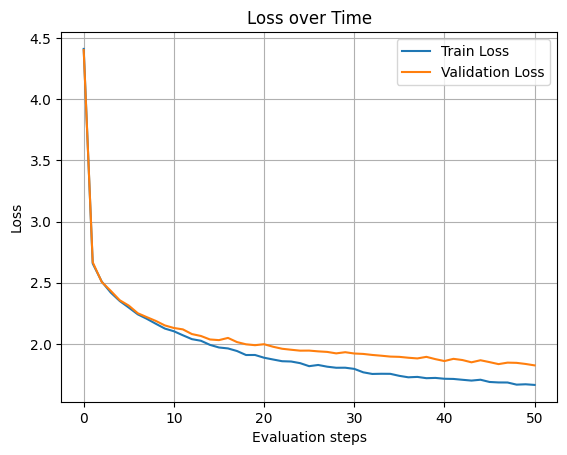

In [6]:
import matplotlib.pyplot as plt
# Plot DLITE losses
plt.figure()
plt.plot(train_losses_cross_entropy, label='Train Loss')
plt.plot(val_losses_cross_entropy, label='Validation Loss')
plt.xlabel('Evaluation steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Time')
plt.grid(True)
plt.show()

# Training with dlite loss


In [7]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    # Define the Cross Entropy loss function here
    ce_loss_func = nn.CrossEntropyLoss()

    out = {}
    ce_out = {}
    model.eval()
    for split in ['train', 'val']:
        dlite_losses = torch.zeros(eval_iters)
        ce_losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, _ = model(X, Y)
            dlite_losses[k] = dlite_loss(logits, Y.view(-1)).item()
            ce_losses[k] = ce_loss_func(logits.view(-1, vocab_size), Y.view(-1)).item()
        out[split] = dlite_losses.mean()
        ce_out[split] = ce_losses.mean()
    model.train()
    return out, ce_out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# DLITE loss function

# class DLITELoss(nn.Module):
#     def __init__(self):
#         super(DLITELoss, self).__init__()

#     def forward(self, P, Q):
#         # Masks for non-zero elements of P and Q
#         # unsqueeze P
#         Q = torch.unsqueeze(Q, 1)
#         Q = torch.cat([Q]*65, dim=1)

#         mask_P = P > 0
#         mask_Q = Q > 0

#         # LIT(P, Q) part
#         LIT_P = torch.zeros_like(P)
#         LIT_Q = torch.zeros_like(Q).float()

#         # Compute only for non-zero elements
#         # print('P: ', (1 - torch.log(P[mask_P])).dtype)
#         # print('Q: ', (1 - torch.log(Q[mask_Q])).dtype)
#         LIT_P[mask_P] = P[mask_P] * (1 - torch.log(P[mask_P]))
#         LIT_Q[mask_Q] = Q[mask_Q] * (1 - torch.log(Q[mask_Q]))

#         # print('LIT_P: ', LIT_P.shape)
#         # print('LIT_Q: ', LIT_Q.shape)
#         LIT_term = torch.sum(torch.abs(LIT_P - LIT_Q))

#         # dH(P, Q) part
#         dH_P = torch.zeros_like(P)
#         dH_Q = torch.zeros_like(Q).float()

#         # Compute only for non-zero elements
#         dH_P[mask_P] = P[mask_P]**2 * (1 - 2*torch.log(P[mask_P]))
#         dH_Q[mask_Q] = Q[mask_Q]**2 * (1 - 2*torch.log(Q[mask_Q]))

#         dH_term = torch.sum(torch.abs(dH_P - dH_Q) / (2 * (P + Q)))

#         # DLITE(P, Q)
#         DLITE = LIT_term - dH_term

#         return DLITE

class DLITELoss(nn.Module):
    def __init__(self):
        super(DLITELoss, self).__init__()

    def forward(self, logits, targets, epsilon=1e-10):
        # Convert logits to probabilities using softmax
        probs = F.softmax(logits, dim=-1)

        # One-hot encode the targets to get true probabilities
        true_probs = F.one_hot(targets, num_classes=probs.size(-1)).float()

        # Define the g function
        g_values = torch.abs(probs * (1 - torch.log(probs + epsilon)) - true_probs * (1 - torch.log(true_probs + epsilon)))

        # Define the delta_h function
        delta_h_values = torch.abs(probs**2 * (1 - 2 * torch.log(probs + epsilon)) - true_probs**2 * (1 - 2 * torch.log(true_probs + epsilon))) / (2 * (probs + true_probs))

        # Compute DLITE loss for each class
        dl_values = g_values - delta_h_values

        # Sum over all classes and average over batch size
        loss = dl_values.sum(dim=-1).mean()

        return loss

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            dlite_loss = DLITELoss()
            # loss = F.cross_entropy(logits, targets)
            loss = dlite_loss(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dlite_loss = DLITELoss()


# Lists to store the loss values
train_losses_dlite = []
val_losses_dlite = []
ce_train_losses_dlite = []
ce_val_losses_dlite = []

for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        dlite_losses, ce_losses = estimate_loss()
        print(f"step {iter}: train loss {dlite_losses['train']:.4f}, val loss {dlite_losses['val']:.4f}, CE train loss: {ce_losses['train']:.4f}, CE val loss {ce_losses['val']:.4f}\n")

        # Append the losses for this iteration
        train_losses_dlite.append(dlite_losses['train'])
        val_losses_dlite.append(dlite_losses['val'])
        ce_train_losses_dlite.append(ce_losses['train'])
        ce_val_losses_dlite.append(ce_losses['val'])


    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the logits
    logits, _ = model(xb, yb)

    # Flatten the logits and target tensor
    logits_flat = logits.view(-1, logits.shape[-1])
    targets_flat = yb.view(-1)

    # Compute the DLITE loss using the flattened logits and targets
    loss = dlite_loss(logits_flat, targets_flat)

    # Backpropagation and optimization step
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.209729 M parameters
step 0: train loss 0.9281, val loss 0.9275, CE train loss: 4.4116, CE val loss 4.4022

step 100: train loss 0.6724, val loss 0.6736, CE train loss: 3.3284, CE val loss 3.4019

step 200: train loss 0.6473, val loss 0.6496, CE train loss: 3.3351, CE val loss 3.4165

step 300: train loss 0.6313, val loss 0.6368, CE train loss: 3.3308, CE val loss 3.4452

step 400: train loss 0.6191, val loss 0.6233, CE train loss: 3.2563, CE val loss 3.3515

step 500: train loss 0.6065, val loss 0.6124, CE train loss: 3.2285, CE val loss 3.3183

step 600: train loss 0.5906, val loss 0.5920, CE train loss: 3.0803, CE val loss 3.1162

step 700: train loss 0.5817, val loss 0.5861, CE train loss: 3.0967, CE val loss 3.1399

step 800: train loss 0.5683, val loss 0.5754, CE train loss: 3.0289, CE val loss 3.0802

step 900: train loss 0.5617, val loss 0.5683, CE train loss: 2.9837, CE val loss 3.0250

step 1000: train loss 0.5567, val loss 0.5635, CE train loss: 3.0957, CE val loss 3.1309



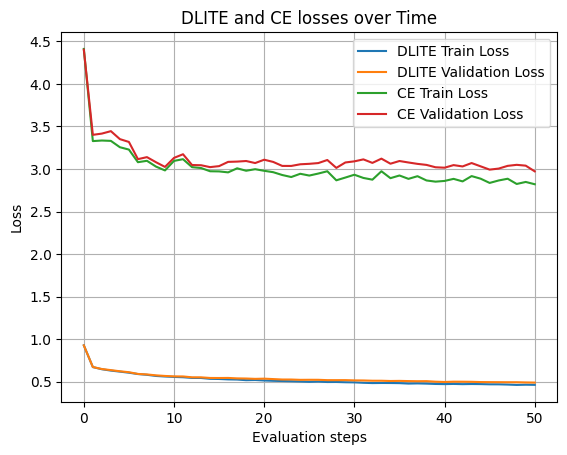

In [8]:
import matplotlib.pyplot as plt

# Plot DLITE and CE losses
plt.figure()
plt.plot(train_losses_dlite, label='DLITE Train Loss')
plt.plot(val_losses_dlite, label='DLITE Validation Loss')
plt.plot(ce_train_losses_dlite, label='CE Train Loss')
plt.plot(ce_val_losses_dlite, label='CE Validation Loss')
plt.xlabel('Evaluation steps')
plt.ylabel('Loss')
plt.legend()
plt.title('DLITE and CE losses over Time')
plt.grid(True)
plt.show()



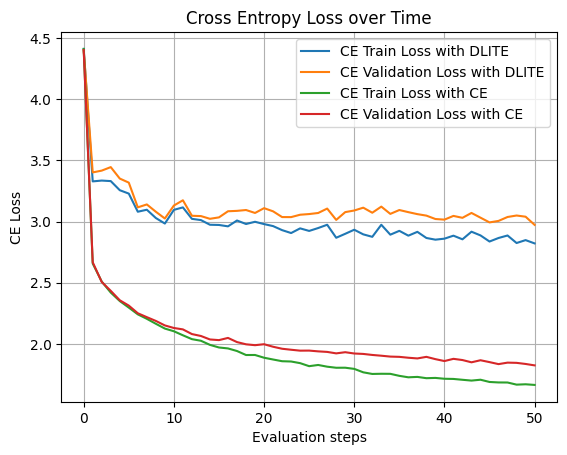

In [10]:
# Compare the cross entropy with DLITE method and CE method
plt.figure()
plt.plot(ce_train_losses_dlite, label='CE Train Loss with DLITE')
plt.plot(ce_val_losses_dlite, label='CE Validation Loss with DLITE')
plt.plot(train_losses_cross_entropy, label='CE Train Loss with CE')
plt.plot(val_losses_cross_entropy, label='CE Validation Loss with CE')
plt.xlabel('Evaluation steps')
plt.ylabel('CE Loss')
plt.legend()
plt.title('Cross Entropy Loss over Time')
plt.grid(True)
plt.show()